In [1]:
# General imports
import os
from IPython.display import Image

# Import required for data conversion
from ndx_beadl import (Task, BEADLTaskProgram, BEADLTaskSchema, EventTypesTable, EventsTable,
                       StateTypesTable, StatesTable, TrialsTable, ActionTypesTable, ActionsTable, TaskArgumentsTable)
from ndx_beadl.beadl_xml_parser import BeadlXMLParser
from pynwb import NWBHDF5IO, NWBFile
from pynwb.file import Subject
import datetime

# Imports and helper functions for visualization
from ndx_beadl.plot import (plot_events, plot_actions, plot_states, plot_trials,
                            compute_state_transition_matrix, plot_state_transition_graph)
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

# Define the paths for the input data files
beadl_schema_file = os.path.abspath(os.path.join(os.getcwd(), "../../src/pynwb/tests/BEADL.xsd"))
beadl_task_file = os.path.abspath(os.path.join(os.getcwd(), "../../src/pynwb/tests/LightChasingTask.xml"))
beadl_path=os.path.abspath(os.path.join(os.getcwd(), "BeadlData.mat"))

# Define the path for the NWB file to write and clean-up if file exists
nwb_filepath = "beadl_test.nwb"
if os.path.exists(nwb_filepath):
    os.remove(nwb_filepath)

# 1. Overview of the ndx-beadl NWB extension

The *ndx_beadl* extension is available online at https://github.com/rly/ndx-beadl/ . The extension defines a collection of interlinked table data structures for storing behavioral tasks and data. While the extension has been designed with BEADL in mind, the data structures are general and are intended to be useful even without BEADL. The data model consists of three main components:

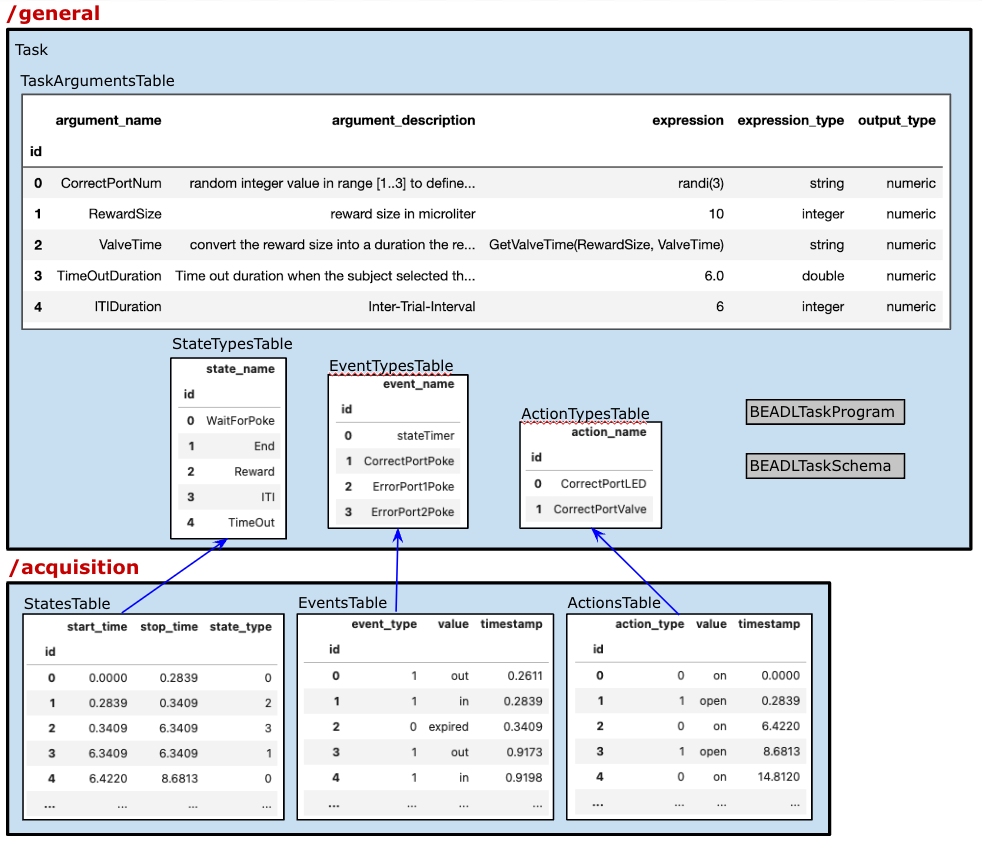

In [2]:
Image(filename="beadl_components_p1.png")

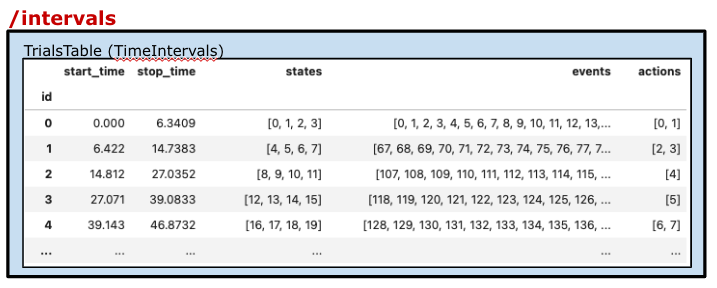

In [3]:
Image(filename="beadl_components_p2.png", width=700)

# 2. Converting BEADL data to NWB

## 2.1 Task metadata
#### 2.1.1 Import the BEADL task schema and task program

In [4]:
with open(beadl_schema_file, "r") as test_xsd_file:
    test_xsd = test_xsd_file.read()

with open(beadl_task_file, "r") as test_xml_file:
    test_xml = test_xml_file.read()

In [5]:
beadl_task_schema = BEADLTaskSchema(
    name = 'task_schema',
    data=test_xsd,
    version="0.1.0",
    language="XSD"
)

beadl_task_program = BEADLTaskProgram(
    name = 'task_program',
    data=test_xml,
    schema=beadl_task_schema,
    language="XML"
)

In [6]:
task_arg_table=TaskArgumentsTable(beadl_task_program=beadl_task_program, populate_from_program=True)

In [7]:
display(task_arg_table.to_dataframe(index=True))


,argument_name,argument_description,expression,expression_type,output_type
id,,,,,
0,CorrectPortNum,random integer value in range [1..3] to define...,randi(3),string,numeric
1,RewardSize,reward size in microliter,10,integer,numeric
2,ValveTime,convert the reward size into a duration the re...,"GetValveTime(RewardSize, ValveTime)",string,numeric
3,TimeOutDuration,Time out duration when the subject selected th...,6.0,double,numeric
4,ITIDuration,Inter-Trial-Interval,6,integer,numeric


#### 2.1.2 Create the EventTypes, ActionTypes, and StateType tables from the task program

In [8]:
event_types = EventTypesTable(description="description", beadl_task_program=beadl_task_program, populate_from_program=True)

In [9]:
action_types= ActionTypesTable(description="description", beadl_task_program=beadl_task_program, populate_from_program=True)

In [10]:
state_types = StateTypesTable(description="description", beadl_task_program=beadl_task_program, populate_from_program=True)

In [11]:
display(event_types.to_dataframe(index=True))
display(action_types.to_dataframe(index=True))
display(state_types.to_dataframe(index=True))

,event_name
id,
0,ErrorPort2Poke
1,stateTimer
2,CorrectPortPoke
3,ErrorPort1Poke


,action_name
id,
0,CorrectPortValve
1,CorrectPortLED


,state_name
id,
0,WaitForPoke
1,End
2,Reward
3,ITI
4,TimeOut


#### 2.1.3 Create a new Tasks object and add the BEADL task metadata

In [12]:
task = Task(
    task_program=beadl_task_program,
    task_schema=beadl_task_schema,
    event_types=event_types,
    state_types=state_types,
    action_types=action_types,
    task_arguments=task_arg_table
)

## 2.2 Behavioral data
#### 2.2.1 Create Events, Actions, and States

In [13]:
events = EventsTable(description="description", event_types_table=event_types)
_ = events.populate_from_matlab(data_path=beadl_path)

In [ ]:
actions = ActionsTable(description="description", action_types_table=action_types)
_ = actions.populate_from_matlab(data_path=beadl_path)

In [ ]:
states = StatesTable(description="description", state_types_table=state_types)
_ = states.populate_from_matlab(data_path=beadl_path)

In [ ]:
events.to_dataframe(index=True)

In [ ]:
actions.to_dataframe(index=True)

In [ ]:
states.to_dataframe(index=True)

#### 2.2.2 Trial data

In [ ]:
trials = TrialsTable(description="description", states_table=states, events_table=events, actions_table=actions)
_ = trials.populate_from_matlab(data_path=beadl_path)

In [ ]:
trials.to_dataframe(index=True)

## 2.3 Creating the NWB file
#### 2.3.1 Create a new NWB file

In [ ]:
nwbfile = NWBFile(
        session_description="session_description",
        identifier="LightChasingTask",
        session_start_time=datetime.datetime.now(datetime.timezone.utc),
        subject=Subject(subject_id="SP_W2_RH")
    )

#### 2.3.2 Add the BEADL behavioral data to the file

In [ ]:
%%capture
# Add the task
nwbfile.add_lab_meta_data(task)

In [ ]:
# Add the StatesTable, EventsTable, and ActionsTable to the acquistion
nwbfile.add_acquisition(states)
nwbfile.add_acquisition(events)
nwbfile.add_acquisition(actions)

In [ ]:
# Add the trials (Note, for custom TimeIntervals we can use nwbfile.add_time_intervals as well)
nwbfile.trials = trials

#### 2.3.3 Write the NWB file

In [ ]:
with NWBHDF5IO(nwb_filepath, mode="w") as io:
    io.write(nwbfile)

# 3. Using BEADL data stored in NWB

## 3.1 Read the NWB file

Since we have here the *ndx_beadl* extension install we can just open the file as usual. If the *ndx_beadl* extension is not installed then we need to set ``load_namespaces=True`` when creating the ``NWBHDF5IO`` object.

In [ ]:
io = NWBHDF5IO(nwb_filepath, mode="r")
read_nwbfile = io.read()

## 3.2 Plot the ``EventsTable``, ``ActionsTable``, and ``StatesTable``

The ``plot_events``, ``plot_actions``, and ``plot_states`` functions can consume both the raw table as well as a subset of the table as a pandas DataFrame created through slicing, e.g., via ``states[0:60]``

In [ ]:
# Get the EventsTable from file
events = read_nwbfile.get_acquisition("events")

# Plot the data
fig = plot_events(events=events,
                  event_types=event_types,
                  show_event_values=True,
                  figsize=(18,4),
                  marker_size=500)
plt.title("Events", fontsize=18)
plt.show()

In [ ]:
# Get the ActionsTable from file
actions = read_nwbfile.get_acquisition("actions")

# Plot the data
fig = plot_actions(actions=actions,
                   action_types=action_types,
                   show_action_values=True,
                   figsize=(18,1.5),
                   marker_size=500)
plt.show()

In [ ]:
# Get the StatesTable from file
states = read_nwbfile.get_acquisition("states")

# Plot the data
plot_states(states=states,
            state_types=state_types,
            marker_size=500)
plt.show()

## 3.3 Plot the ``TrialsTable``

In [ ]:
# Get the TrialsTable from file
trials = read_nwbfile.trials

# Plot trial 46 - 50
plot_trials(
    trials=trials[46:51],
    states=states, state_types=state_types,
    actions=actions, action_types=action_types,
    events=events, event_types=event_types,
    figsize=None,
    fontsize=18,
    rectangle_height=1,
    marker_size=500)
plt.show()

## 3.4 Compute and plot the state transition matrix

Here we compute the state transition matrix for all states throughout the experiment. However, simply by subsetting the ``StatesTable`` we can also create the transition matrix for any subset of state transitions, e.g., by selecting only the states from a subset of trials based on the ``TrialsTable``

In [ ]:
# Get the StatesTable from file
states = read_nwbfile.get_acquisition("states")

# Compute the transition count and probablity matrix
state_transition_count_df, state_transition_probability_df = compute_state_transition_matrix(states=states, state_types=state_types)

In [ ]:
display(state_transition_count_df)
display(state_transition_probability_df)

In [ ]:
fig = plot_state_transition_graph(
    state_transition_probability_df,
    figsize=(13,7),
    edge_color='darkblue',
    edge_font_color='darkblue',
    node_font_color='red',
    fontsize=14
)
plt.show()